This notebook runs a pilot study in which all components of the unfolding problem example pipeline are executed including:
1. Generating Data
    - Perform a quick and dirty coverage study using the quantile obtained elsewhere
2. Rough coverage study with OSB, Oracle, and constant adaOSB
3. Generating polytopes
4. Sampling from polytopes
5. Sampling from null LLR distributions
6. Fitting quantile regression
7. Computing intervals

In [1]:
from adaFuncCI.data_generation import unfoldingGenerator
from adaFuncCI.llr import llrSolver
from adaFuncCI.optimize import osb_int
from adaFuncCI.utils import int_cover, find_cis
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from tqdm.notebook import tqdm

In [2]:
with open('./data/unfold_true_dim80_smear_dim40/unfolding_data_00.npz', 'rb') as f:
    data_obj = np.load(f)
    y_tilde = data_obj['y_tilde']
    K_tilde = data_obj['K_tilde']
    h = data_obj['h']
    alpha = float(data_obj['alpha'])
    eta = float(data_obj['eta'])
    gamma = float(data_obj['gamma'])
    
# problem dimesions
n, p = K_tilde.shape

# 1 - Generate Data

In [3]:
# create unfolding object
unfold_obj = unfoldingGenerator(dim_true=80, dim_smear=40)

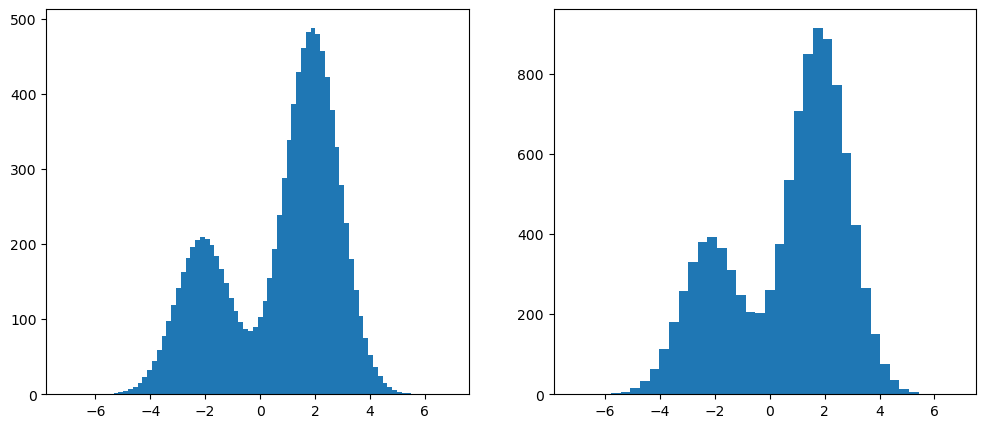

In [4]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(12, 5))
WIDTH_TRUE = unfold_obj.edges_true[1] - unfold_obj.edges_true[0]
WIDTH_SMEAR = unfold_obj.edges_smear[1] - unfold_obj.edges_smear[0]
ax[0].bar(x=unfold_obj.edges_true[:-1], height=unfold_obj.means_true, width=WIDTH_TRUE)
ax[1].bar(x=unfold_obj.edges_smear[:-1], height=unfold_obj.means_smear, width=WIDTH_SMEAR)
plt.show()

In [5]:
# sample data
NUM_SAMP = 1000
data = unfold_obj.sample_ensemble(num_elements=NUM_SAMP)

# transform
data_tilde = data @ unfold_obj.L_data_inv.T

# 2 - Rough run with OSB, Oracle, and adaOSB

#### Estimate the oracle quantile

In [6]:
# define the true functional value
mu_true = np.dot(h, unfold_obj.means_true)

# upper quantile level
ALPHA = 0.32

# sample data
M = 10000
np.random.seed(112358)
noise_orcl = stats.multivariate_normal(mean=np.zeros(n), cov=np.identity(n)).rvs(M)
data_orcl = K_tilde @ unfold_obj.means_true + noise_orcl
print(data_orcl.shape)

(10000, 40)


In [7]:
# create the llr solver
llr_solver = llrSolver(K=K_tilde, h=h)

In [ ]:
llr_samp = np.zeros(M)
for i in tqdm(range(M)):
    llr_samp[i] = llr_solver.solve_llr(y=data_orcl[i], mu=mu_true)[0]

In [10]:
# estimate 1 - ALPHA quantile and ci
orcl_q_est = np.percentile(llr_samp, q=(1 - ALPHA) * 100)
orcl_q_ci = find_cis(llr_samp[np.newaxis, :], alpha_quantile=ALPHA, alpha_interval=0.05, window_ub=100)
print(orcl_q_est)
print(orcl_q_ci)

0.06684350394220191
[[0.06431361 0.0697828 ]]


#### Estimate coverage for three settings

In [18]:
# quantile settings
q_osb = stats.chi2(df=1).ppf(1 - ALPHA)
q_adaosb = 0.367

intervals = np.zeros(shape=(3, NUM_SAMP, 2))  # 0: OSB - 1: adaOSB - 2: oracle
for i in tqdm(range(NUM_SAMP)):
    
    # OSB
    intervals[0, i, :] = osb_int(y=data_tilde[i], q=q_osb, K=unfold_obj.K_tilde, h=h)

    # adaOSB
    intervals[1, i, :] = osb_int(y=data_tilde[i], q=q_adaosb, K=unfold_obj.K_tilde, h=h)

    # oracle
    intervals[2, i, :] = osb_int(y=data_tilde[i], q=orcl_q_est, K=unfold_obj.K_tilde, h=h)

  0%|          | 0/1000 [00:00<?, ?it/s]

/Users/mikestanley/anaconda3/envs/mc_sampling/lib/python3.8/site-packages/cvxpy/problems/problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


In [11]:
# compute coverage
coverage = np.zeros(shape=(NUM_SAMP, 3))  # 0: OSB - 1: adaOSB - 2: oracle
for i in range(NUM_SAMP):
    coverage[i, 0] = int_cover(mu_true=mu_true, interval=intervals[0, i, :])
    coverage[i, 1] = int_cover(mu_true=mu_true, interval=intervals[1, i, :])
    coverage[i, 2] = int_cover(mu_true=mu_true, interval=intervals[2, i, :])

In [12]:
print('Estimated Coverages')
print('OSB | adaOSB | Oracle')
coverage.mean(axis=0)

Estimated Coverages
OSB | adaOSB | Oracle


array([0.993, 0.944, 0.671])

In [13]:
# look at interval lengths
osb_mean_len = (intervals[0, :, 1] - intervals[0, :, 0]).mean()
adaosb_mean_len = (intervals[1, :, 1] - intervals[1, :, 0]).mean()
oracle_mean_len = (intervals[2, :, 1] - intervals[2, :, 0]).mean()
print(f'OSB mean length    : {osb_mean_len}')
print(f'adaOSB mean length : {adaosb_mean_len}')
print(f'Oracle mean length : {oracle_mean_len}')

OSB mean length    : 1718.227188991122
adaOSB mean length : 1306.1654598189316
Oracle mean length : 677.986542129349


# 3 - Create Polytope

In [12]:
from adaFuncCI.sample import polytopeSampler
import json

In [13]:
# acquire MCMC sampler settings
MCMC_PARAM_FP = './data/parameter_settings_mcmc/mcmc_parameters0.json'
with open(MCMC_PARAM_FP, 'rb') as f:
    mcmc_params = json.load(f)
    
print(mcmc_params)

{'chain_length': 25000, 'num_hp': 200, 'random_seed_hp_gen': 112358, 'radius': 0.5, 'alpha': 0.32, 'eta': 0.01, 'burn_in': 10000, 'functional_idx': 6, 'polytope_type': 'eigen+random', 'mcmc_alg': 'vaidya'}


In [14]:
# instantiate sampler
OBS_IDX = 100
eigen_sampler = polytopeSampler(
    y=data_tilde[OBS_IDX],
    eta=mcmc_params["eta"],
    K=K_tilde,
    h=h,
    N_hp=mcmc_params['num_hp'],
    r=0.5,
    random_seed=mcmc_params["random_seed_hp_gen"],
    polytope_type=mcmc_params['polytope_type'],
    alg=mcmc_params["mcmc_alg"],
    disable_tqdm=False
)

# look at the ssb interval
print(eigen_sampler.ssb_interval)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:05<00:00, 33.75it/s]
/Users/mikestanley/anaconda3/envs/mc_sampling/lib/python3.8/site-packages/cvxpy/problems/problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


(1815.1531980426118, 5272.42630868622)


# 4 - Sample from polytope

In [15]:
from time import time

In [69]:
# set chain parameters
M = 21000
# mix_grid = [0.03, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35]
mix_grid = [0.05, 0.1, 0.2, 0.4, 0.6, 0.8, 0.95]
# mix_grid = [0.05, 0.3, 0.5, 0.7, 0.95]

print(M / (2 * len(mix_grid)))

1500.0


In [30]:
# take a look at the starting point functional values to make sure we're getting a good spread
grid_size = 2 * len(mix_grid)
start_points = np.zeros(shape=(grid_size, K_tilde.shape[1]))

for i, t in enumerate(mix_grid):

    # mix with LB
    start_points[i, :] = (1 - t) * eigen_sampler.x_lb_ssb + t * eigen_sampler.cheb_center

    # mix with UB
    start_points[
        i + len(mix_grid), :
    ] = (1 - t) * eigen_sampler.x_ub_ssb + t * eigen_sampler.cheb_center
start_points @ h

array([1866.75380042, 2124.7568123 , 2331.15922181, 2537.56163131,
       2795.56464319, 5151.16325553, 4544.84798975, 4059.79577713,
       3574.74356451, 2968.42829873])

In [31]:
# sample chains
START = time()

chain_train = eigen_sampler.sample_mixed_ensemble(
    M=M, mix_grid=mix_grid
)
print(f'Train set sampled | Elapsed time: {time() - START} seconds')

chain_test = eigen_sampler.sample_mixed_ensemble(
    M=M, mix_grid=mix_grid, burn_in=100
)
print(f'Test set sampled | Elapsed time: {time() - START} seconds')

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:16<00:00, 13.70s/it]


Train set sampled | Elapsed time: 137.0234968662262 seconds


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:17<00:00, 13.75s/it]

Test set sampled | Elapsed time: 274.52718591690063 seconds


In [32]:
# compute functional values across these samples to assess mixing
chain_f_train = chain_train @ h
chain_f_test = chain_test @ h

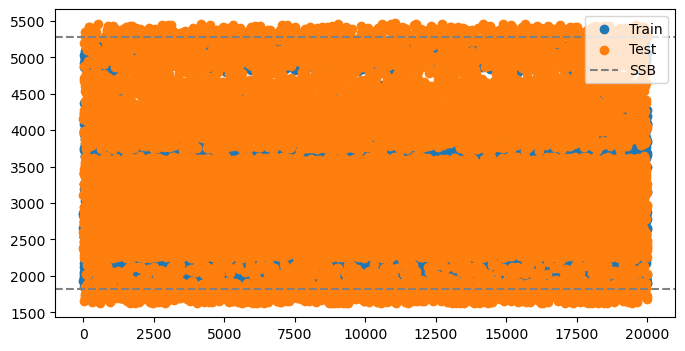

In [33]:
plt.figure(figsize=(8, 4))
plt.scatter(np.arange(M), chain_f_train, label='Train')
plt.scatter(np.arange(M), chain_f_test, label='Test')
plt.axhline(eigen_sampler.ssb_interval[0], label='SSB', linestyle='--', color='gray')
plt.axhline(eigen_sampler.ssb_interval[1], linestyle='--', color='gray')
# plt.xlim(0, 100)
plt.legend()
plt.show()

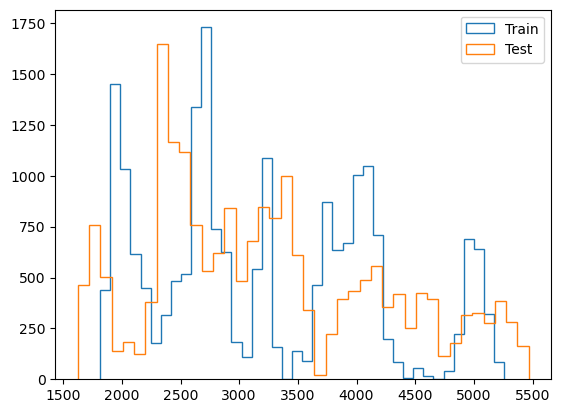

In [34]:
plt.hist(chain_f_train, bins=40, histtype='step', label='Train')
plt.hist(chain_f_test, bins=40, histtype='step', label='Test')
plt.legend()
plt.show()

# 5 - Sample from null LLR distributions

In [38]:
from adaFuncCI.sample import nullTestStatSampler

In [39]:
# instantiate the nullTestStatSampler object
teststat_samp = nullTestStatSampler(
    noise_distr=stats.norm,
    test_stat=llr_solver,
    K=K_tilde, h=h,
    disable_tqdm=False
)

In [40]:
# sample from llr null distributions defined by the polytope train sample
llr_samples = teststat_samp.sample_teststat(
    param_vals=chain_train, random_seed=3145
)

  1%|█▌                                                                                                           | 278/20000 [00:08<10:03, 32.67it/s]/Users/mikestanley/anaconda3/envs/mc_sampling/lib/python3.8/site-packages/cvxpy/problems/problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [14:56<00:00, 22.31it/s]


# 6 - Fit quantile regression

In [43]:
from adaFuncCI.max_quantile import maxQuantileQR

In [44]:
# instantiate the object
qr = maxQuantileQR(
    X_train=chain_train, X_test=chain_test, y_train=llr_samples, q=gamma, hyperparams=None
)

In [45]:
# find the max in/out sample quantiles
qr.estimate(random_state_reg=0, random_state_cv=1)

In [46]:
print('--- Estimated quantiles ---')
print(f'In-sample  : {qr.maxq_insample.max()}')
print(f'Out-sample : {qr.maxq_outsample.max()}')

--- Estimated quantiles ---
In-sample  : 2.543418424490258
Out-sample : 2.7550412762417067


In [47]:
# display hyperparameters to save for coverage study
qr.hyperparams_dict

{'min_samples_split': 30,
 'min_samples_leaf': 1,
 'max_depth': 2,
 'learning_rate': 0.1,
 'n_estimators': 150}

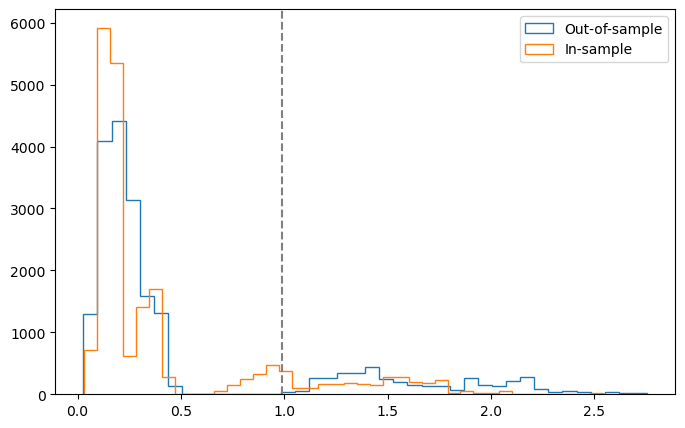

In [48]:
# look at distribution of predicted quantiles
predicted_oos_quantiles = qr.gbt.predict(chain_test)
predicted_is_quantiles = qr.gbt.predict(chain_train)

plt.figure(figsize=(8, 5))
plt.hist(predicted_oos_quantiles, bins=40, histtype='step', label='Out-of-sample')
plt.hist(predicted_is_quantiles, bins=40, histtype='step', label='In-sample')
plt.axvline(stats.chi2(1).ppf(0.68), linestyle='--', color='gray')
plt.legend()
plt.show()

In [49]:
# what's going on with that very large prediction?
chain_f_test[predicted_oos_quantiles.argmax()], chain_f_test.max()

(1648.7587732773225, 5467.219326512222)

In [50]:
chain_f_train[predicted_is_quantiles.argmax()], chain_f_train.max()

(5040.583249245995, 5258.311488251249)

# 7 - Compute intervals

Interval to compute:
1. MQ Direct -- Accept/Reject points based on max oos quantile
2. MQ Opt -- Optimize interval using max oos quantile
3. MQmu Param -- Accept/Reject points based on their LLR with data being less than oos quantile
4. MQmu func -- Accept/Reject functional points based on estimated max quantile function
5. OSB Interval

In [51]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

In [52]:
def I_vals(qoi_arr, mu_grid):
    """
    Assigns index {0,...,N} to each value in qoi_arr where N
    is the total number of bins
    """
    bin_assign = np.zeros_like(qoi_arr)
    for i, qoi in enumerate(qoi_arr):
        
        # smallest index where less than
        lt_i = np.where(qoi <= mu_grid)[0][0]
        
        bin_assign[i] = lt_i - 1 if lt_i > 0 else 0
        
    return bin_assign

def max_over_bins(qoi_arr, mu_grid, q_hat):
    """
    Given grid of mu's, find the max predicted quantile over each.
    
    Parameters
    ----------
        qoi_arr (np arr) : quantity of interest values
        mu_grid (np arr) : grid boundary points
        q_hat   (np arr) : predicted quantile values
    """
    # assign each point to bin via QoI
    bin_assigns = I_vals(qoi_arr=qoi_arr, mu_grid=mu_grid)
    
    max_quantiles = np.zeros(mu_grid.shape[0] - 1)
    for k in range(mu_grid.shape[0] - 1):
        
        # indices where bin is k
        bin_k_idx = np.where(bin_assigns == k)[0]
        
        # max quantile for that bin
        max_quantiles[k] = q_hat[bin_k_idx].max()
        
    return max_quantiles

def solve_llr_fixed_y(qoi_vals, y, K, h=h, disable_tqdm=True):
    """
    Solves the LLR for a collection of mu values and one fixed y.
    """
    # instantiate llr
    llr_solver = llrSolver(K=K, h=h)
    
    # solve opt2 once
    opt_2_sol = llr_solver.solve_opt2(y=y)[0]
    
    # solve opt1 for each mu
    opt_1_sols = np.zeros(qoi_vals.shape[0])
    for i in tqdm(range(qoi_vals.shape[0]), disable=disable_tqdm):
        opt_1_sols[i] = llr_solver.solve_opt1(y=y, mu=qoi_vals[i])[0]
        
    return opt_1_sols - opt_2_sol

def compute_intervals(
    y, qoi_vals, q_hat_vals, K, h,
    num_mu_grid, alpha,
    disable_tqdm=True
):
    """
    Computes four intervals:
    1. MQ - Direct inversion
    2. MQ - Optimized
    3. MQmu - Parameter space inversion
    4. MQmu - Functional space inversion

    NOTE: this function requires precomputed test functional values
    and precomputed quantile predictions at test points.

    NOTE: for the mu-functional interval, instead of re-computing the
    llr over a new grid, we simply use the original llr computations
    over the test QoI values for the grid by sorting.

    Parameters
    ----------
        i            (int)    : iteration index for parallelization
        y            (np arr) : observation vector
        qoi_vals     (np arr) : function values at test points
        q_hat_vals   (np arr) : QR predictions at test points
        K            (np arr) : linear forward model
        h            (np arr) : linear functional
        num_mu_grid  (int)    : number of mu grid elements
        alpha        (float)  : 1 - confidence level
        disable_tqdm (bool)   : toggles progress bar for llr values

    Returns
    -------
        mq_direct   (tup)
        mq_opt      (tup)
        mq_mu_param (tup)
        mq_mu_func  (tup)
        osb         (tup)
    """
    # solve for the LLR at each sampled functional value
    llr_vals_qoi_test = solve_llr_fixed_y(
        qoi_vals=qoi_vals,
        y=y,
        K=K,
        h=h,
        disable_tqdm=disable_tqdm
    )

    # --- MQ direct
    admissible_qoi_direct_idxs = llr_vals_qoi_test <= q_hat_vals.max()
    if admissible_qoi_direct_idxs.sum() < 2:
        mq_direct = (qoi_vals.min(), qoi_vals.max())
    else:
        mq_direct = (
            qoi_vals[admissible_qoi_direct_idxs].min(),
            qoi_vals[admissible_qoi_direct_idxs].max()
        )

    # --- MQ Opt
    mq_opt = osb_int(y=y, q=q_hat_vals.max(), K=K, h=h)

    # --- MQmu param
    admissible_qoi_idxs = llr_vals_qoi_test <= q_hat_vals
    if admissible_qoi_idxs.sum() < 2:
        mq_mu_param = (qoi_vals.min(), qoi_vals.max())
    else:
        mq_mu_param = (
            qoi_vals[admissible_qoi_idxs].min(),
            qoi_vals[admissible_qoi_idxs].max()
        )

    # --- MQmu func
    # create mu grid
    mu_grid = np.linspace(
        qoi_vals.min(), qoi_vals.max(), num=num_mu_grid + 1
    )
    max_q_grid = max_over_bins(
        qoi_arr=qoi_vals, mu_grid=mu_grid, q_hat=q_hat_vals
    )

    # fit the GP Reg
    gpr = GaussianProcessRegressor(
        kernel=RBF(length_scale=1e2), random_state=0
    ).fit(mu_grid[:-1][:, np.newaxis], max_q_grid)

    # get sorted versions of previous qoi and llr arrays
    qoi_sort_idx = np.argsort(qoi_vals)
    qoi_vals_sorted = qoi_vals[qoi_sort_idx].copy()
    llr_vals_sorted = llr_vals_qoi_test[qoi_sort_idx].copy()

    # evaluate fitted regression function over qoi_vals values
    m_mu_gp_test = gpr.predict(qoi_vals_sorted[:, np.newaxis])

    # obtain interval by finding smallest/largest_indices
    zero_idxs = np.where(m_mu_gp_test - llr_vals_sorted >= 0)[0]
    if zero_idxs.shape[0] < 2:
        mq_mu_func = (qoi_vals_sorted[0], qoi_vals_sorted[-1])
    else:
        mq_mu_func = (
            qoi_vals_sorted[zero_idxs[0]],
            qoi_vals_sorted[zero_idxs[-1]]
        )

    # --- OSB Interval
    osb = osb_int(y=y, q=stats.chi2(1).ppf(1 - alpha), K=K, h=h)

    print(f'Iteration {i} | Intervals Computed')

    return (
        mq_direct,
        mq_opt,
        mq_mu_param,
        mq_mu_func,
        osb,
        llr_vals_qoi_test,
        m_mu_gp_test
    )

In [53]:
# true functional value?
np.dot(h, unfold_obj.means_true)

3598.2487934782844

In [54]:
# solve for the LLR at each sampled functional value
llr_vals_qoi_test = solve_llr_fixed_y(
    qoi_vals=chain_f_test,
    y=data_tilde[OBS_IDX],
    K=K_tilde,
    h=h,
    disable_tqdm=False
)

  0%|          | 0/20000 [00:00<?, ?it/s]

In [56]:
# OSB for comparison
osb_opt = osb_int(y=data_tilde[OBS_IDX], q=stats.chi2(1).ppf(0.68), K=K_tilde, h=h)
print(osb_opt)

(2414.865199803989, 4294.827625258442)


In [57]:
# MQ Direct
mq_direct = (
    chain_f_test[llr_vals_qoi_test <= predicted_oos_quantiles.max()].min(),
    chain_f_test[llr_vals_qoi_test <= predicted_oos_quantiles.max()].max()
)
print(mq_direct)

(2281.413638795094, 4462.453193721742)


In [58]:
# MQ Opt
mq_opt = osb_int(y=data_tilde[OBS_IDX], q=predicted_oos_quantiles.max(), K=K_tilde, h=h)
print(mq_opt)

(2281.2222073406483, 4462.453482165726)


In [59]:
# MQmu param
mq_mu_param = (
    chain_f_test[llr_vals_qoi_test <= predicted_oos_quantiles].min(),
    chain_f_test[llr_vals_qoi_test <= predicted_oos_quantiles].max()
)
print(mq_mu_param)

(2534.207490630085, 4087.935574939526)


In [97]:
# MQmu func
NUM_MU_GRID = 20
M = 20000

# get sorted versions of previous qoi and llr arrays
qoi_sort_idx = np.argsort(chain_f_test)
qoi_vals_sorted = chain_f_test[qoi_sort_idx].copy()
llr_vals_sorted = llr_vals_qoi_test[qoi_sort_idx].copy()

# produce a grid across the actual sampled functional values
mu_grid = qoi_vals_sorted[np.arange(start=M/NUM_MU_GRID, stop=M + 1 / M, step=M/NUM_MU_GRID, dtype=int) - 1]
# np.linspace(
#     chain_f_test.min(), chain_f_test.max(), num=NUM_MU_GRID + 1
# )
max_q_grid = max_over_bins(
    qoi_arr=chain_f_test, mu_grid=mu_grid, q_hat=predicted_oos_quantiles
)

In [100]:
# fit the GP Reg
gpr = GaussianProcessRegressor(
    kernel=RBF(length_scale=1e2), random_state=0, alpha=0.2
).fit(mu_grid[:-1][:, np.newaxis], max_q_grid)

# evaluate fitted regression function over qoi_vals values
m_mu_gp_test = gpr.predict(qoi_vals_sorted[:, np.newaxis])

# obtain interval by finding smallest/largest_indices
zero_idxs = np.where(m_mu_gp_test - llr_vals_sorted >= 0)[0]
if zero_idxs.shape[0] < 2:
    mq_mu_func = (qoi_vals_sorted[0], qoi_vals_sorted[-1])
else:
    mq_mu_func = (
        qoi_vals_sorted[zero_idxs[0]],
        qoi_vals_sorted[zero_idxs[-1]]
    )
print(mq_mu_func)

(2556.5460517368124, 4348.314932512722)


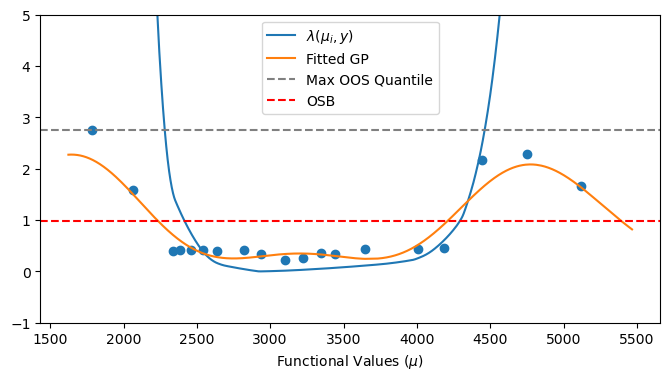

In [101]:
plt.figure(figsize=(8, 4))
plt.plot(qoi_vals_sorted, llr_vals_sorted, label=r'$\lambda(\mu_i, y)$')

plt.plot(qoi_vals_sorted, m_mu_gp_test, label='Fitted GP')
plt.scatter(mu_grid[:-1], max_q_grid)

plt.axhline(predicted_oos_quantiles.max(), linestyle='--', label='Max OOS Quantile', color='gray')
plt.axhline(stats.chi2(1).ppf(0.68), linestyle='--', label='OSB', color='red')
plt.ylim(-1, 5)

plt.xlabel(r'Functional Values ($\mu$)')
plt.legend()
plt.show()

In [64]:
print('-- Intervals --')
print(f'MQ Direct  : {mq_direct}')
print(f'MQ Opt     : {mq_opt}')
print(f'MQmu Param : {mq_mu_param}')
print(f'MQmu func  : {mq_mu_func}')
print(f'OSB        : {osb_opt}')

-- Intervals --
MQ Direct  : (2281.413638795094, 4462.453193721742)
MQ Opt     : (2281.2222073406483, 4462.453482165726)
MQmu Param : (2534.207490630085, 4087.935574939526)
MQmu func  : (2531.620115841273, 4403.565308677664)
OSB        : (2414.865199803989, 4294.827625258442)
